In [1]:
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Dataset Processing from Directory**

In [2]:
img_size = [227,227] #List which stores the resolution
main_train = '../input/crack-detection/Main/Train' #Stores the path of the train directory
main_test = '../input/crack-detection/Main/Test' #Stores the path of the test directory

# **Image Augmentation**

In [3]:
#ImageDataGenerator is used to modify the train and test images w.r.t the properties mentioned
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1/255.0)

# flow_from_directory() Takes the path to a directory & generates batches of augmented data.
training_set = train_datagen.flow_from_directory(directory = main_train,
                                                 target_size = (227,227),
                                                 batch_size = 500,
                                                 )

test_set = test_datagen.flow_from_directory(directory = main_test,
                                                 target_size = (227,227),
                                                 batch_size = 500,
                                                 )

Found 32042 images belonging to 2 classes.
Found 7958 images belonging to 2 classes.


# **VGG19 Model Building**

In [4]:
mob_model = MobileNetV2(include_top=False,
    weights="imagenet",
    input_shape=(227,227,3))

# Loading the mobilenetv2 pre trained model

# include_top - this specifies whether the final layer before the output layer has to be include 
# or not. If included then there will be huge number of classes at the output.

# Weights are trained using imagenet

2021-10-22 15:21:28.361843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 15:21:28.450000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 15:21:28.450723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 15:21:28.451976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [5]:
mob_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 114, 114, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 114, 114, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [6]:
# To fix the weights of the pre trained model
i=0
for layer in mob_model.layers:
    layer.trainable = False
    i+=1

print(i)
mob_model.summary()

154
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 114, 114, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 114, 114, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________

In [7]:
# Flatten() is used to convert the last layer to vector or as fully connected
x = Flatten(name="first_flatten")(mob_model.output)
# Dense() layer is added such that it outputs only two classess 
# Softmax activation layer produces probabilities for different classess.
x = Dense(2,activation='softmax')(x)
# Model() is used to group layers
model = Model(inputs=mob_model.input,outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 114, 114, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 114, 114, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
# Loss function is used to find the errors or deviations in learning process
# Optimizer is used to optimize the input weights
# Metrics is used to measure the performance
model.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=['accuracy'])

# **Model Fitting**

In [9]:
# fit() is used to train the model 
# len(training_set) is 32042/500 = 65
# len(test_set) is 7958/500 = 16
mobilemod = model.fit(
  training_set,
  validation_data=test_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set))

2021-10-22 15:21:40.173184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2021-10-22 15:21:51.416443: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 573s 9s/step - loss: 0.4165 - accuracy: 0.9630 - val_loss: 0.0505 - val_accuracy: 0.9954
Epoch 2/2
65/65 [==============================] - 393s 6s/step - loss: 0.0632 - accuracy: 0.9950 - val_loss: 0.0308 - val_accuracy: 0.9967


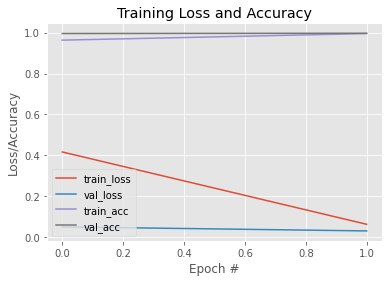

In [10]:
from matplotlib import pyplot as plt
N = 2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), mobilemod.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), mobilemod.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), mobilemod.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), mobilemod.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('grp.png')

In [11]:
# To save the particular model in .h5 format
import tensorflow as tf
from tensorflow.keras.models import load_model
model.save('mobilenetv2modelfinal.h5') 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
